# Algoritmo HOG (Histogram of Oriented Gradients)

En este notebook exploraremos el funcionamiento del algoritmo HOG, una técnica eficaz para extraer y representar características locales en imágenes mediante el cálculo de gradientes orientados en pequeñas celdas. HOG se ha consolidado como una herramienta robusta para la detección de objetos, especialmente en la identificación de peatones, ya que al combinar la descripción detallada de la estructura visual con la normalización de bloques, logra ser invariante frente a variaciones de iluminación y posición. 

Además, evaluaremos la eficiencia del algoritmo al integrarlo con un modelo SVM, que potencia su capacidad para discriminar correctamente la presencia de humanos en diferentes escenarios.

# Paso 1: Cargar y Mostra la imagen

Antes de comenzar con el algoritmo, debemos de importar las librerías necesarias y cargar la imagen con la que vamos a trabajar.

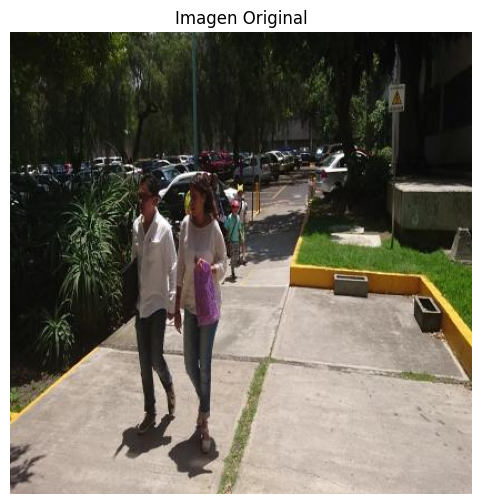

In [1]:

import cv2
import algoritmos.hog as hog
import matplotlib.pyplot as plt

ruta_imagen1 = '../src/images/test/MOV_0572_mp4-7_jpg.rf.20fa68cf07d4cf30c7534fe8d53ca117.jpg'
ruta_image2 = '../src/images/test/seq_001996_jpg.rf.5ca557b1a02e0ba073ee7c7334d1b211.jpg'

img = cv2.imread(ruta_imagen1)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")
plt.axis("off")
plt.show()

# Paso 2: Escalar la Imagen
Escalar la imagen consiste en ajustar sus dimensiones para adecuarlas a los requerimientos del procesamiento y optimizar el rendimiento del algoritmo. Esto es especialmente útil porque:

- **Ajuste de Resolución:** Cambiar la escala permite adaptar el tamaño de la imagen a las necesidades específicas del análisis, resaltando detalles relevantes o reduciendo el ruido.

- **Eficiencia Computacional:** Al trabajar con una imagen de dimensiones optimizadas, se reduce la carga computacional, lo que acelera el procesamiento sin comprometer la información esencial.

- **Optimización para Detección:** Ajustar el tamaño puede mejorar la precisión en la detección de características, ya que se utiliza una escala adecuada para el algoritmo en uso.

Aunque en algunos casos se pueden procesar imágenes a su tamaño original, escalar la imagen de forma controlada permite equilibrar la calidad visual y el rendimiento del sistema.


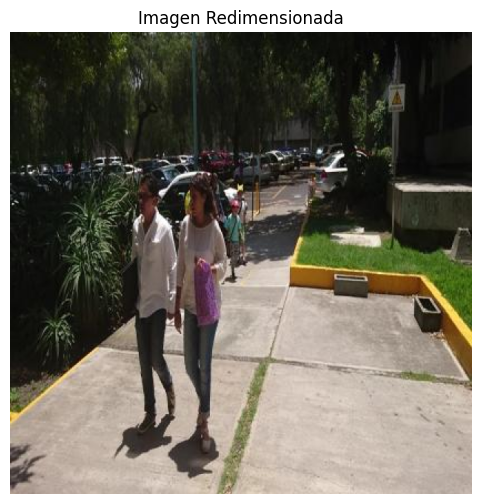

In [2]:
scale_percent = 150  # Incrementa o reduce este valor según necesites
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
img_resized = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

# Mostrar la imagen redimensionada
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title("Imagen Redimensionada")
plt.axis("off")
plt.show()


# Paso 3: Configuración del Detector HOG
En este paso se definen y configuran los parámetros del detector HOG:

- **cell_size:** Tamaño en píxeles de cada celda, donde se calcula el histograma de gradientes (por ejemplo, (8,8)).
- **block_size:** Número de celdas que conforman un bloque, utilizado para normalizar los histogramas.
- **block_stride:** Desplazamiento en píxeles del bloque en la imagen, permitiendo solapamientos que mejoran la detección.
- **nbins:** Número de bins en el histograma de orientaciones, que determina la granularidad en la representación de los gradientes.
- **win_stride:** Paso de la ventana deslizante durante el proceso de detección.
- **padding:** Tamaño del relleno aplicado a la imagen para gestionar adecuadamente los bordes durante la detección.
- **scale:** Factor de escala entre ventanas, facilitando la detección de objetos a diferentes resoluciones.

Posteriormente, se crea el objeto HOG mediante la clase hog_detect, inicializando el descriptor con una ventana de tamaño estándar (64,128) para la detección de peatones.

In [3]:
cell_size = (8, 8)
block_size = (2, 2)
block_stride = (8, 8)
nbins = 9
win_stride = (8, 8)
padding = (16, 16)
scale = 1.05

detector = hog.hog_detect(cell_size, block_size, block_stride, nbins, win_stride, padding, scale)


# Paso 4: Construcción del Descriptor HOG
Para construir el descriptor HOG se analiza la distribución de gradientes en la imagen, lo que permite capturar la información estructural y de contornos de manera robusta ante variaciones de iluminación y escala. El proceso se resume en los siguientes pasos:

1. **Cálculo del Gradiente:**
Se determina la variación de intensidad en cada píxel mediante la aplicación de operadores como Sobel, calculando las derivadas en las direcciones x e y. La magnitud del gradiente se define como:
 $$
𝑀(𝑥,𝑦)= sqrt(𝐺𝑥(𝑥,𝑦)^2+𝐺𝑦(𝑥,𝑦)^2)
$$
​
 
y la orientación se obtiene con:

𝜃
(
𝑥
,
𝑦
)
=
arctan
⁡
(
𝐺
𝑦
(
𝑥
,
𝑦
)
𝐺
𝑥
(
𝑥
,
𝑦
)
)
θ(x,y)=arctan( 
G 
x
​
 (x,y)
G 
y
​
 (x,y)
​
 )
Construcción del Histograma:
La imagen se divide en celdas de tamaño fijo (por ejemplo, 8×8 píxeles). En cada celda se construye un histograma donde se acumulan las magnitudes de los gradientes según su orientación, distribuidas en un número determinado de bins (por ejemplo, 9). Cada píxel contribuye al bin correspondiente de acuerdo con su ángulo, ponderado por su magnitud.

Normalización en Bloques:
Las celdas se agrupan en bloques (por ejemplo, bloques de 2×2 celdas) y se normalizan sus histogramas. Este proceso mejora la invariancia ante cambios de iluminación y contraste, ya que se ajustan los valores locales en función del contexto de la vecindad.

Concatenación de Histogramas:
Finalmente, los histogramas normalizados de todos los bloques se concatenan para formar el descriptor HOG final, que es un vector de características que resume la distribución de orientaciones en la imagen.

In [4]:
hog_descriptor = detector.compute_hog(img)
print("Forma del HOG descriptor:", hog_descriptor.shape)



AttributeError: 'hog_detect' object has no attribute 'bin_width'

In [ ]:
# Celda 6: Detectar humanos en la imagen usando el detector HOG
rects, weights = detector.detect_humans(img, threshold=0.5)
print("Rectángulos de detección:", rects)
print("Pesos de detección:", weights)

In [ ]:
# Celda 7: Dibujar las detecciones en la imagen
img_detections = detector.draw_detections(img, rects)

In [ ]:
# Celda 8: Mostrar la imagen con las detecciones
detector.draw_img(img_detections, axis="off")